Testing whether including the errorbars actually makes a difference...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import corner
import emcee

In [2]:
def model(pars, x):
    return pars[0] * x + pars[1]

In [3]:
def lnprior(pars):
    if -10 < pars[0] < 10 and -10 < pars[1] < 10 and -10 < pars[2] < 10:
        return 0.
    else:
        return -np.inf

In [4]:
def lnprob(pars, x, y, yerr):
    return lnprior(pars) + lnlike(pars, x, y, yerr)

In [5]:
def lnlike(pars, x, y, yerr):
    invsig2 = 1./(yerr**2 + np.exp(2*pars[2]))
    model_y = model(pars, x)
    return -.5*np.sum((y-model_y)**2*invsig2 - np.log(invsig2))

params =  -0.525509606298 2.88909102256


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


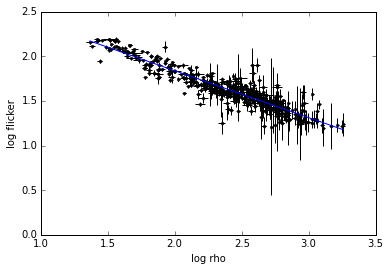

In [6]:
# load data
f, ferr, r, rerr = np.genfromtxt("../data/flickers.dat").T

# fit a line
AT = np.vstack((r, np.ones_like(r)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print("params = ", m, c)

# plot data with best fit line
xs = np.linspace(min(r), max(r), 100)
ys = m * xs + c
plt.errorbar(r, f, xerr=rerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log rho")

Results from the simple model

In [7]:
pars_init = [m, c, np.log(3)]
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(r, f, ferr))
sampler.run_mcmc(pos, 10000)  # run MCMC
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
samples[:, 2] = np.exp(samples[:, 2])

In [8]:
m1, c1, sig1 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


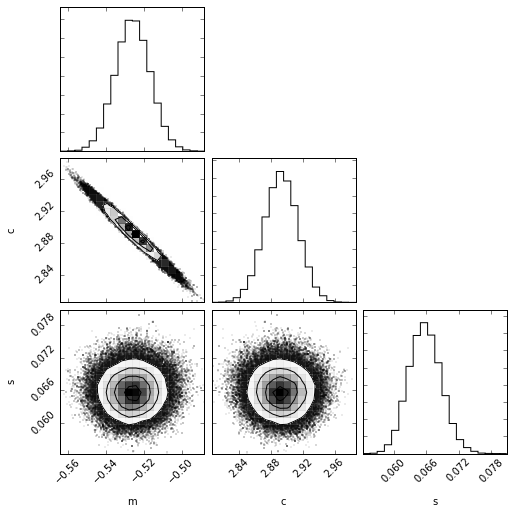

In [10]:
fig = corner.corner(samples, labels=["m", "c", "s"])
#print(sig1[0])
#print(1./(ferr**2 + np.exp(2*pars[2])))

Now the analytic errorbar version

In [11]:
def analytic_lnlike(pars, x, y, xerr, yerr):
    m, b, lns = pars
    sig2 = (m*xerr)**2 + (yerr**2 + np.exp(2*lns))
    ll = -.5 * np.sum((m*x-y+b)**2/sig2 + np.log(sig2))
    return ll

In [12]:
def analytic_lnprob(pars, x, y, xerr, yerr):
    return lnprior(pars) + analytic_lnlike(pars, x, y, xerr, yerr)

In [13]:
pars_init = [m, c, np.log(3)]
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, analytic_lnprob, args=(r, f, rerr, ferr))
sampler.run_mcmc(pos, 10000)  # run MCMC
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
samples[:, 2] = np.exp(samples[:, 2])
m2, c2, ln_sig2 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


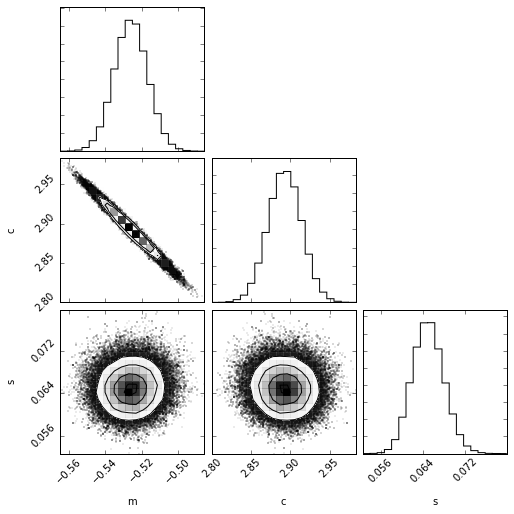

In [14]:
fig = corner.corner(samples, labels=["m", "c", "s"])

The results are pretty consistent!

In [15]:
print(m1)
print(m2)
print((m1[0] - m2[0])/ m1[1])

(-0.52585065090731975, 0.0091822592896774191, 0.0091487957936710051)
(-0.52590477738205466, 0.0091784573480356846, 0.0091750765074660734)
0.00589467940594


In [16]:
print(c1)
print(c2)
print((c1[0] - c2[0])/ c1[1])

(2.8926122225490856, 0.021056424455969225, 0.021123428333467587)
(2.8928784443955884, 0.021144667730461641, 0.02133936733934938)
-0.0126432598782


In [20]:
print(sig1)
print(ln_sig2)
print((sig1[0] - ln_sig2[0])/ sig1[1])

(0.065744500795268057, 0.0030352699403901617, 0.002910784314101536)
(0.064928267094832015, 0.0030264673654257085, 0.0029180351964236267)
0.268916345652


# Now for logg

params =  -0.826618949099 4.90659568177


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


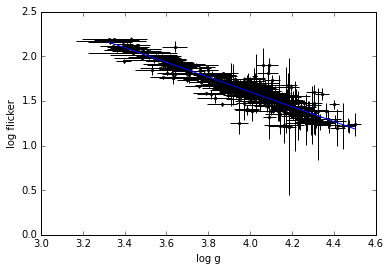

In [21]:
# load data
f, ferr, l, lerr, _, _ = np.genfromtxt("../data/log.dat").T

# fit a line
AT = np.vstack((l, np.ones_like(r)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print("params = ", m, c)

# plot data with best fit line
xs = np.linspace(min(l), max(l), 100)
ys = m * xs + c
plt.errorbar(l, f, xerr=lerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log g")

Simple first:

In [22]:
pars_init = [m, c, np.log(3)]
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(l, f, ferr))
sampler.run_mcmc(pos, 10000)  # run MCMC
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
samples[:, 2] = np.exp(samples[:, 2])

In [31]:
m1, c1, ln_sig1 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


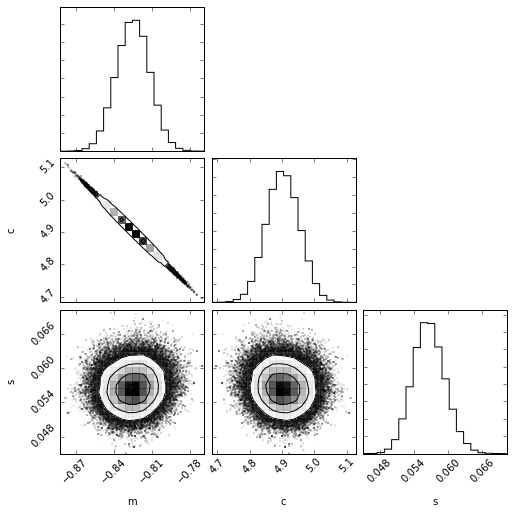

In [32]:
fig = corner.corner(samples, labels=["m", "c", "s"])

Now analytic:

In [26]:
pars_init = [m, c, np.log(3)]
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, analytic_lnprob, args=(l, f, rerr, ferr))
sampler.run_mcmc(pos, 10000)  # run MCMC
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
samples[:, 2] = np.exp(samples[:, 2])
m2, c2, ln_sig2 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


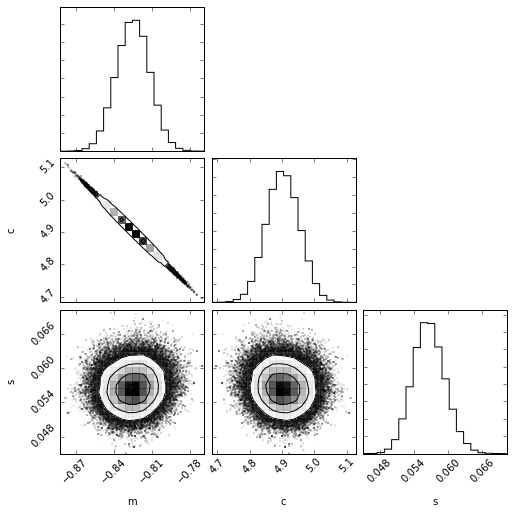

In [27]:
fig = corner.corner(samples, labels=["m", "c", "s"])

In [28]:
print(m1)
print(m2)
print((m1[0] - m2[0])/ m1[1])

(-0.82397481736797828, 0.013034250282421556, 0.012961846743813621)
(-0.82478401960505476, 0.012929414138373341, 0.013257119050247179)
0.0620827603846


In [29]:
print(c1)
print(c2)
print((c1[0] - c2[0])/ c1[1])

(4.8988950084944385, 0.050234635819534468, 0.050791262181840935)
(4.902533342750262, 0.051483567445117728, 0.05030178941125385)
-0.0724268066538


In [30]:
print(sig1)
print(ln_sig2)
print((sig1[0] - ln_sig2[0])/ sig1[1])

(0.05890452418444108, 0.0027861708642643798, 0.0026537685458079066)
(0.056560564673172109, 0.002904656957598159, 0.0027092497489685369)
0.841283476664
